In [1]:
import pandas as pd
import numpy as np
import seaborn

#Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
%matplotlib inline

#preprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#ML libraries
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

#Metrics Libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#Misc libraries
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Function for Confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
# Read data
df = pd.read_csv('../data/PS_20174392719_1491204439457_log.csv')
df = df.sample(frac = 1)

# Check target
df.isFraud.value_counts()
# sample is unbalanced

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [4]:
# Take a part of the sample so that it is balanced
df_0 = df[df.isFraud == 0].iloc[:10000, :]
df_1 = df[df.isFraud == 1]
df = pd.concat([df_0,df_1])
df.isFraud.value_counts()

isFraud
0    10000
1     8213
Name: count, dtype: int64

In [5]:
# Check dublicated rows
df.duplicated().sum()

np.int64(0)

In [6]:
# Check NaN
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
5916589,404,TRANSFER,113208.23,C1935645456,0.00,0.00,C1192472312,12230604.57,12343812.79,0,0
1713286,160,CASH_OUT,339701.76,C1517300986,0.00,0.00,C383164027,473621.87,813323.63,0,0
3283284,251,PAYMENT,16856.46,C1940639164,0.00,0.00,M1304304109,0.00,0.00,0,0
4524916,326,TRANSFER,1269708.46,C568168512,11764.00,0.00,C1830622921,0.00,1269708.46,0,0
4808491,346,CASH_IN,114574.22,C1634662526,6306684.95,6421259.17,C560680219,221151.64,106577.42,0,0


## Visualize data ##

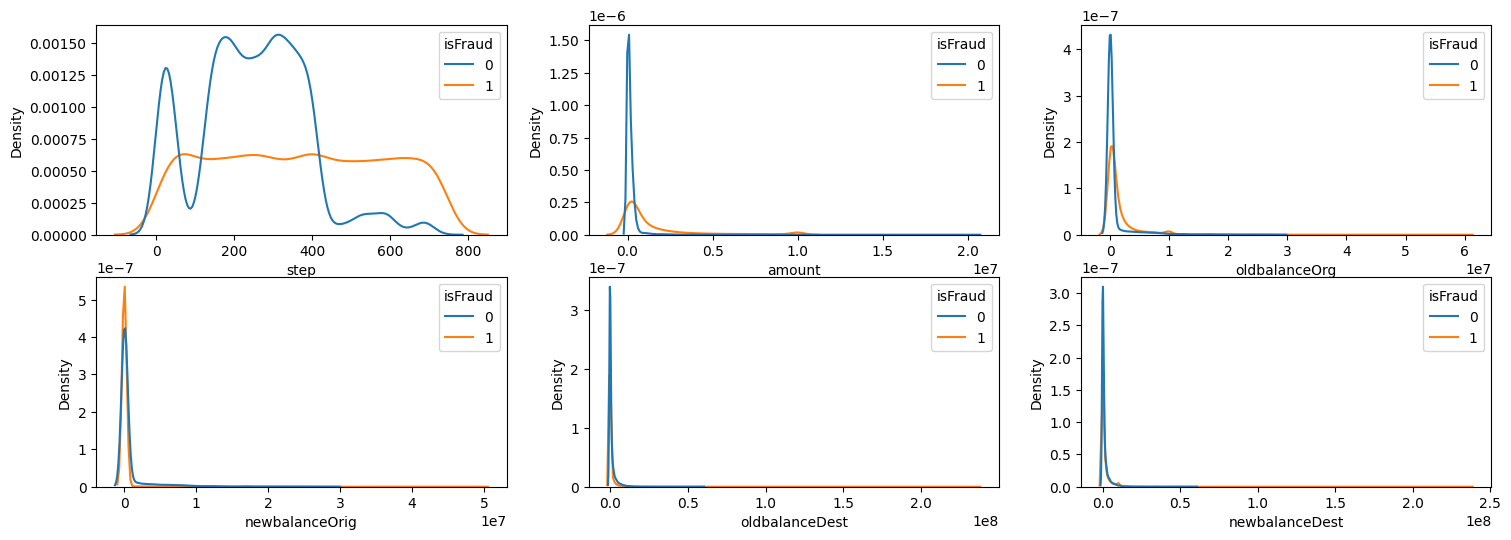

In [8]:
fig, axes = plt.subplots(2,3, figsize = (18,6))
i,j = [0,0]
for num_col in list(df._get_numeric_data().columns[:-2]):
    sns.kdeplot(data = df, x = num_col, hue = 'isFraud', ax = axes[i][j] )
    j+=1
    if j == 3:
        j = 0
        i += 1

Существуют транзакции с очень большими суммами. Стоит отмечать такие пеерводы. Найдем 75%-квантиль

In [9]:
thresh = int(df.describe().loc['75%', 'amount'])
thresh

462177

Из категриальных признаков интересен только type

<Axes: xlabel='type', ylabel='Count'>

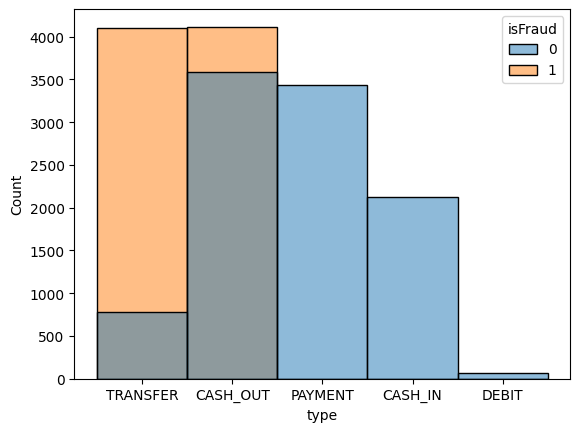

In [10]:
sns.histplot(data = df, x = 'type',  hue = 'isFraud')

In [11]:
# Drop extra column
df = df.copy().drop(['isFlaggedFraud'], axis = 1)
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
5916589,404,TRANSFER,113208.23,C1935645456,0.00,0.00,C1192472312,12230604.57,12343812.79,0
1713286,160,CASH_OUT,339701.76,C1517300986,0.00,0.00,C383164027,473621.87,813323.63,0
3283284,251,PAYMENT,16856.46,C1940639164,0.00,0.00,M1304304109,0.00,0.00,0
4524916,326,TRANSFER,1269708.46,C568168512,11764.00,0.00,C1830622921,0.00,1269708.46,0
4808491,346,CASH_IN,114574.22,C1634662526,6306684.95,6421259.17,C560680219,221151.64,106577.42,0
...,...,...,...,...,...,...,...,...,...,...
6281808,652,CASH_OUT,92043.22,C784347509,92043.22,0.00,C1769542876,3090723.25,3182766.47,1
6232503,593,CASH_OUT,125146.75,C1198861647,125146.75,0.00,C490114096,1820417.69,1945564.44,1
6196334,573,TRANSFER,457789.14,C2120513600,457789.14,0.00,C975127788,0.00,0.00,1
3960325,296,CASH_OUT,40593.23,C1911506122,40593.23,0.00,C1767820890,173347.80,213941.02,1


In [12]:
df_old = pd.read_csv('../data/PS_20174392719_1491204439457_log.csv')

Как часто встречается имя получателя в изначальном датасете

In [13]:
df_old.groupby("nameDest").count().sort_values(['type'], ascending = False)['step'].to_dict()

{'C1286084959': 113,
 'C985934102': 109,
 'C665576141': 105,
 'C2083562754': 102,
 'C248609774': 101,
 'C1590550415': 101,
 'C451111351': 99,
 'C1789550256': 99,
 'C1360767589': 98,
 'C1023714065': 97,
 'C977993101': 96,
 'C97730845': 96,
 'C392292416': 95,
 'C1899073220': 92,
 'C306206744': 91,
 'C1782113663': 90,
 'C1234776885': 90,
 'C998351292': 89,
 'C716083600': 89,
 'C909295153': 88,
 'C1674899618': 86,
 'C667346055': 86,
 'C1262822392': 85,
 'C453211571': 84,
 'C1255024717': 84,
 'C1816757085': 84,
 'C2006081398': 83,
 'C932583850': 82,
 'C1504109395': 82,
 'C991363637': 82,
 'C1303868418': 81,
 'C728526866': 81,
 'C1721246982': 80,
 'C1909597726': 80,
 'C766681183': 80,
 'C11003494': 80,
 'C1883840933': 80,
 'C1870252780': 80,
 'C33524623': 80,
 'C214774813': 80,
 'C1167066016': 79,
 'C662736689': 79,
 'C769342184': 78,
 'C423580937': 77,
 'C803116137': 77,
 'C1850180796': 76,
 'C1297685781': 76,
 'C1730752455': 76,
 'C2049813033': 75,
 'C863811613': 75,
 'C914293025': 75,
 'C

In [14]:
# Save dict
freq_dict = df_old.groupby("nameDest").count().sort_values(['type'], ascending = False)['step'].to_dict()

<Axes: >

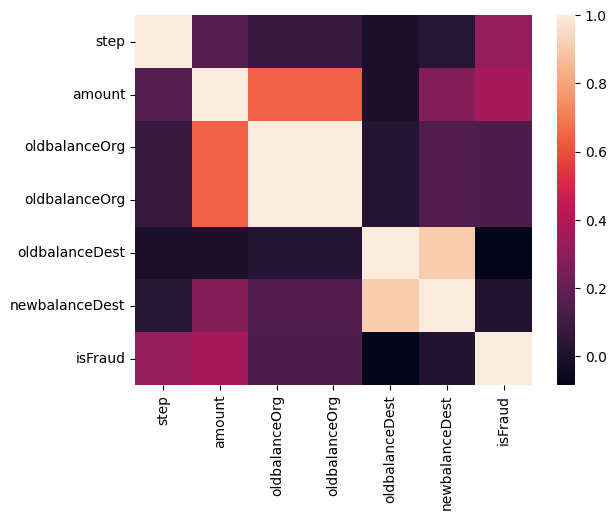

In [15]:
# Plot Correlation Matrix with seaborn
corr = df.loc[:, ['step', 'amount', 'oldbalanceOrg', 'oldbalanceOrg',
                   'oldbalanceDest', 'newbalanceDest','isFraud']].corr()
sns.heatmap(corr)

## Feature engeneering ##

1. Разница в балансе. Отметим, что сумма, списанная со счета отправителя, зачисляется на счет получателя без отклонений в центах. Но что делать, если существует отклонение в дебетовой и кредитовой суммах. Некоторые из них могут быть вызваны комиссиями, взымаемыми поставщиками услуг

2. Индикатор всплеска: Также нам необходимо установить флаг, когда в транзакцию вовлечена большая сумма. Из распределения сумм мы поняли, что у нас много выбросов с большими суммами в транзакциях. Поэтому в качестве порога мы рассматриваем 75-й процентиль (thresh), а сумма, превышающая tresh, будет отмечена флажком.

3. Индикатор частоты: Здесь мы отмечаем пользователя. Когда получатель получает деньги от многих людей, это может стать триггером, так как это может быть связано с некоторыми незаконными азартными играми. Поэтому флаг ставится, если получатель получает деньги более 20 раз.

4.  Индикатор торговца: Идентификаторы клиентов в приемнике начинаются с 'M', что означает, что они являются торговцами и, очевидно, у них будет много транзакций по приему денег. Поэтому мы также отмечаем, когда есть получатель-торговец.

In [16]:
# Difference balances
df['balance_diff_orig'] = df['newbalanceOrig']-df['oldbalanceOrg']
df['balance_diff_dest'] = df['newbalanceDest']-df['oldbalanceDest']
df = df.drop(['newbalanceOrig', 'oldbalanceOrg', 'newbalanceDest','oldbalanceDest' ], axis =1)
df

,step,type,amount,nameOrig,nameDest,isFraud,balance_diff_orig,balance_diff_dest
5916589,404,TRANSFER,113208.23,C1935645456,C1192472312,0,0.00,113208.22
1713286,160,CASH_OUT,339701.76,C1517300986,C383164027,0,0.00,339701.76
3283284,251,PAYMENT,16856.46,C1940639164,M1304304109,0,0.00,0.00
4524916,326,TRANSFER,1269708.46,C568168512,C1830622921,0,-11764.00,1269708.46
4808491,346,CASH_IN,114574.22,C1634662526,C560680219,0,114574.22,-114574.22
...,...,...,...,...,...,...,...,...
6281808,652,CASH_OUT,92043.22,C784347509,C1769542876,1,-92043.22,92043.22
6232503,593,CASH_OUT,125146.75,C1198861647,C490114096,1,-125146.75,125146.75
6196334,573,TRANSFER,457789.14,C2120513600,C975127788,1,-457789.14,0.00
3960325,296,CASH_OUT,40593.23,C1911506122,C1767820890,1,-40593.23,40593.22


In [17]:
# Surge indicator
df['surge']=[1 if n > thresh else 0 for n in df['amount']]

In [18]:
#Frequency indicator
df['freq_Dest'] = df.nameDest.apply(lambda x: freq_dict[x]).values
df['freq_dest']=[1 if n>20 else 0 for n in df['freq_Dest']]
df = df.drop(['freq_Dest'], axis = 1)
df

,step,type,amount,nameOrig,nameDest,isFraud,balance_diff_orig,balance_diff_dest,surge,freq_dest
5916589,404,TRANSFER,113208.23,C1935645456,C1192472312,0,0.00,113208.22,0,1
1713286,160,CASH_OUT,339701.76,C1517300986,C383164027,0,0.00,339701.76,0,0
3283284,251,PAYMENT,16856.46,C1940639164,M1304304109,0,0.00,0.00,0,0
4524916,326,TRANSFER,1269708.46,C568168512,C1830622921,0,-11764.00,1269708.46,1,0
4808491,346,CASH_IN,114574.22,C1634662526,C560680219,0,114574.22,-114574.22,0,0
...,...,...,...,...,...,...,...,...,...,...
6281808,652,CASH_OUT,92043.22,C784347509,C1769542876,1,-92043.22,92043.22,0,0
6232503,593,CASH_OUT,125146.75,C1198861647,C490114096,1,-125146.75,125146.75,0,0
6196334,573,TRANSFER,457789.14,C2120513600,C975127788,1,-457789.14,0.00,0,0
3960325,296,CASH_OUT,40593.23,C1911506122,C1767820890,1,-40593.23,40593.22,0,0


In [19]:
df.freq_dest.value_counts()

freq_dest
0    15300
1     2913
Name: count, dtype: int64

In [20]:
#Tracking the receiver as merchant or not
values = ['M']
conditions = list(map(df['nameDest'].str.contains, values))
df['merchant'] = np.select(conditions, '1', '0')
df

,step,type,amount,nameOrig,nameDest,isFraud,balance_diff_orig,balance_diff_dest,surge,freq_dest,merchant
5916589,404,TRANSFER,113208.23,C1935645456,C1192472312,0,0.00,113208.22,0,1,0
1713286,160,CASH_OUT,339701.76,C1517300986,C383164027,0,0.00,339701.76,0,0,0
3283284,251,PAYMENT,16856.46,C1940639164,M1304304109,0,0.00,0.00,0,0,1
4524916,326,TRANSFER,1269708.46,C568168512,C1830622921,0,-11764.00,1269708.46,1,0,0
4808491,346,CASH_IN,114574.22,C1634662526,C560680219,0,114574.22,-114574.22,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6281808,652,CASH_OUT,92043.22,C784347509,C1769542876,1,-92043.22,92043.22,0,0,0
6232503,593,CASH_OUT,125146.75,C1198861647,C490114096,1,-125146.75,125146.75,0,0,0
6196334,573,TRANSFER,457789.14,C2120513600,C975127788,1,-457789.14,0.00,0,0,0
3960325,296,CASH_OUT,40593.23,C1911506122,C1767820890,1,-40593.23,40593.22,0,0,0


## One-hot Encoding ##

In [21]:
paysim_1= 1* pd.concat([df,pd.get_dummies(df['type'], prefix='type_')],axis=1)
paysim_1.drop(['type'],axis=1,inplace = True)
paysim_1.head()

,step,amount,nameOrig,nameDest,isFraud,balance_diff_orig,balance_diff_dest,surge,freq_dest,merchant,type__CASH_IN,type__CASH_OUT,type__DEBIT,type__PAYMENT,type__TRANSFER
5916589,404,113208.23,C1935645456,C1192472312,0,0.00,113208.22,0,1,0,0,0,0,0,1
1713286,160,339701.76,C1517300986,C383164027,0,0.00,339701.76,0,0,0,0,1,0,0,0
3283284,251,16856.46,C1940639164,M1304304109,0,0.00,0.00,0,0,1,0,0,0,1,0
4524916,326,1269708.46,C568168512,C1830622921,0,-11764.00,1269708.46,1,0,0,0,0,0,0,1
4808491,346,114574.22,C1634662526,C560680219,0,114574.22,-114574.22,0,0,0,1,0,0,0,0


## Split and Normalize ##

In [22]:
paysim_2=paysim_1.copy()

paysim_2 = paysim_2.drop(['nameOrig','nameDest'], axis = 1)
X=paysim_2.drop('isFraud',axis=1)
y=paysim_2['isFraud']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=111)

In [23]:
X_train

,step,amount,balance_diff_orig,balance_diff_dest,surge,freq_dest,merchant,type__CASH_IN,type__CASH_OUT,type__DEBIT,type__PAYMENT,type__TRANSFER
5563735,388,6703831.40,-6703831.40,0.00,1,0,0,0,0,0,0,1
2554956,206,311570.94,0.00,311570.94,0,0,0,0,1,0,0,0
5212853,370,205557.29,205557.29,-205557.29,0,0,0,1,0,0,0,0
6362595,741,144945.34,-144945.34,144945.34,0,0,0,0,1,0,0,0
3645020,275,47072.98,-35558.91,0.00,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
425835,18,577151.89,0.00,1391938.21,1,1,0,0,1,0,0,0
4505042,325,33206.91,-33206.91,33206.90,0,0,0,0,1,0,0,0
3317560,252,1755.17,0.00,0.00,0,0,1,0,0,0,1,0
6362379,724,89845.29,-89845.29,89845.29,0,0,0,0,1,0,0,0


In [24]:
#Standardizing the numerical columns
scaler = StandardScaler().fit(X_train)
X_train  = scaler.transform(X_train)
X_test= scaler.transform(X_test)

## Training ##

In [25]:
logreg_cv = LogisticRegression(solver='liblinear',random_state=123)
dt_cv=DecisionTreeClassifier(random_state=123)
knn_cv=KNeighborsClassifier()
svc_cv=SVC(kernel='linear',random_state=123)
nb_cv=GaussianNB()
rf_cv=RandomForestClassifier(random_state=123)
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'SVC',4:'Naive Bayes',5:'Random Forest'}
cv_models=[logreg_cv,dt_cv,knn_cv,svc_cv,nb_cv,rf_cv]


for i,model in enumerate(cv_models):
    print("{} Test Recall: {}".format(cv_dict[i],cross_val_score(model, X_train, y_train, cv=2, scoring ='recall').mean()))

Logistic Regression Test Recall: 0.9102340202584701
Decision Tree Test Recall: 0.958085923856095
KNN Test Recall: 0.9451624170450577
SVC Test Recall: 0.9065665385958784
Naive Bayes Test Recall: 1.0
Random Forest Test Recall: 0.9690883688438701


In [26]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=2, n_jobs=-1)
nbModel_grid.fit(X_train, y_train)
print(nbModel_grid.best_estimator_)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
GaussianNB(var_smoothing=np.float64(0.43287612810830584))


Confusion matrix, without normalization


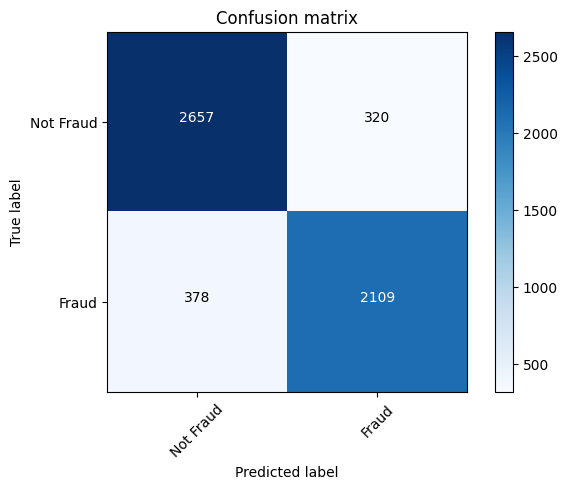

In [27]:
y_pred = nbModel_grid.predict(X_test)

#Plotting confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Not Fraud','Fraud'])

In [28]:
#Classification metrics
print(classification_report(y_test, y_pred, target_names=['Not Fraud','Fraud']))

              precision    recall  f1-score   support

   Not Fraud       0.88      0.89      0.88      2977
       Fraud       0.87      0.85      0.86      2487

    accuracy                           0.87      5464
   macro avg       0.87      0.87      0.87      5464
weighted avg       0.87      0.87      0.87      5464



In [29]:
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam

In [30]:
X_train.shape

(12749, 12)

In [31]:
model = Sequential()
model.add(Dense(86, activation='relu', input_shape=(12,)))
model.add(Dense(43, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
#adam_opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['recall'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 86)             │         1,118 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         3,741 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,760 (22.50 KB)

 Trainable params: 5,760 (22.50 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 2)

Epoch 1/10
319/319 - 1s - 3ms/step - loss: 0.2750 - recall: 0.8562 - val_loss: 0.2016 - val_recall: 0.8437
Epoch 2/10
319/319 - 0s - 876us/step - loss: 0.1587 - recall: 0.9102 - val_loss: 0.1551 - val_recall: 0.8921
Epoch 3/10
319/319 - 0s - 871us/step - loss: 0.1382 - recall: 0.9234 - val_loss: 0.1503 - val_recall: 0.8782
Epoch 4/10
319/319 - 0s - 896us/step - loss: 0.1280 - recall: 0.9317 - val_loss: 0.1449 - val_recall: 0.8946
Epoch 5/10
319/319 - 0s - 871us/step - loss: 0.1207 - recall: 0.9396 - val_loss: 0.1500 - val_recall: 0.8929
Epoch 6/10
319/319 - 0s - 874us/step - loss: 0.1145 - recall: 0.9413 - val_loss: 0.1349 - val_recall: 0.8964
Epoch 7/10
319/319 - 0s - 890us/step - loss: 0.1137 - recall: 0.9420 - val_loss: 0.1431 - val_recall: 0.9585
Epoch 8/10
319/319 - 0s - 884us/step - loss: 0.1115 - recall: 0.9479 - val_loss: 0.1235 - val_recall: 0.9128
Epoch 9/10
319/319 - 0s - 871us/step - loss: 0.1156 - recall: 0.9451 - val_loss: 0.1201 - val_recall: 0.9439
Epoch 10/10
319/319 -

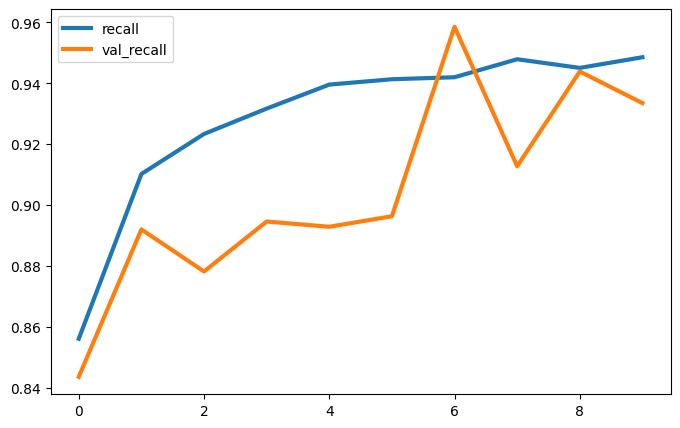

In [33]:
plt.figure(figsize = (8,5))
plt.plot(history.history['recall'], lw = 3)
plt.plot(history.history['val_recall'], lw=3)
plt.legend(['recall', 'val_recall'])

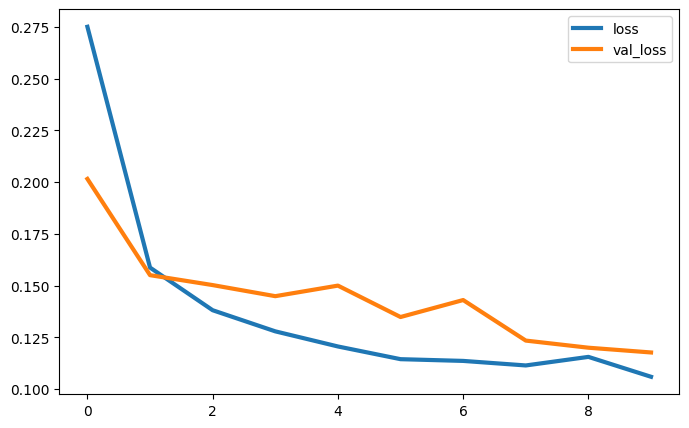

In [34]:
plt.figure(figsize = (8,5))
plt.plot(history.history['loss'], lw = 3)
plt.plot(history.history['val_loss'], lw=3)
plt.legend(['loss', 'val_loss'])